In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()
(digit_x_train, digit_y_train), (digit_x_test, digit_y_test) = tf.keras.datasets.mnist.load_data()

fashion_x_train = fashion_x_train.reshape(60000, 28, 28)/255
fashion_x_test = fashion_x_test.reshape(10000, 28, 28)/255
digit_x_train = digit_x_train.reshape(60000, 28, 28)/255
digit_x_test = digit_x_test.reshape(10000, 28, 28)/255

In [3]:
input_layer = tf.keras.layers.Input(digit_x_train.shape[1:])
x = tf.keras.layers.Flatten()(input_layer)

main_x = tf.keras.layers.Dense(100, activation = 'relu')(x)
ood_x = tf.keras.layers.Dense(100, activation = 'relu')(x)

for _ in range(4):
    ood_x = tf.keras.layers.Concatenate()([main_x, ood_x])
    ood_x = tf.keras.layers.Dense(100, activation = 'relu')(ood_x)
    main_x = tf.keras.layers.Dense(100, activation = 'relu')(main_x)
    
ood_x = tf.keras.layers.Concatenate()([main_x, ood_x])
main_output = tf.keras.layers.Dense(10, activation = 'softmax')(main_x)
ood_output = tf.keras.layers.Dense(28*28, activation = 'sigmoid')(ood_x)

model = tf.keras.models.Model(input_layer, [main_output, ood_output])
model.compile(
    loss = ['sparse_categorical_crossentropy', 'cosine_similarity'],
    optimizer = 'adam'
)
model.summary()

Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          78500       flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       flatten[0][0]                    
________________________________________________________________

2021-10-29 10:43:31.705116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-29 10:43:31.705238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.03, patience = 3, restore_best_weights = True)
model.fit(
    digit_x_train,
    [digit_y_train, digit_x_train.reshape(digit_x_train.shape[0], -1)],
    epochs = 100,
    batch_size = 512,
    validation_split = 0.2,
    callbacks = [callback]
)

2021-10-29 10:43:32.421322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-29 10:43:32.422135: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-10-29 10:43:32.666340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 0.0303 - dense_10_loss: 0.6461 - dense_11_loss: -0.6158

2021-10-29 10:43:35.437126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 3s 30ms/step - loss: 0.0303 - dense_10_loss: 0.6461 - dense_11_loss: -0.6158 - val_loss: -0.4471 - val_dense_10_loss: 0.2230 - val_dense_11_loss: -0.6702
Epoch 2/100
94/94 [==============================] - 2s 26ms/step - loss: -0.5121 - dense_10_loss: 0.1954 - dense_11_loss: -0.7075 - val_loss: -0.5796 - val_dense_10_loss: 0.1547 - val_dense_11_loss: -0.7343
Epoch 3/100
94/94 [==============================] - 2s 23ms/step - loss: -0.6362 - dense_10_loss: 0.1365 - dense_11_loss: -0.7727 - val_loss: -0.6685 - val_dense_10_loss: 0.1354 - val_dense_11_loss: -0.8039
Epoch 4/100
94/94 [==============================] - 2s 23ms/step - loss: -0.7204 - dense_10_loss: 0.1065 - dense_11_loss: -0.8268 - val_loss: -0.7322 - val_dense_10_loss: 0.1129 - val_dense_11_loss: -0.8451
Epoch 5/100
94/94 [==============================] - 2s 23ms/step - loss: -0.7806 - dense_10_loss: 0.0850 - dense_11_loss: -0.8656 - val_loss: -0.7675 - val_dense_10_loss: 0.1113 - 

In [5]:
preds, autoencode = model.predict(digit_x_test)
test_similarities = tf.keras.losses.cosine_similarity(digit_x_test.astype('float32').reshape(10000, 784), autoencode.astype('float32')).numpy()
in_domain_similarities = test_similarities
preds = preds.argmax(axis = 1)

2021-10-29 10:43:55.916743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [6]:
threshold = in_domain_similarities.mean() + 1.5*in_domain_similarities.std()

In [7]:
print(classification_report(digit_y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.98      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.99      0.96      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.97      0.97       958
           7       0.96      0.97      0.96      1028
           8       0.97      0.96      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



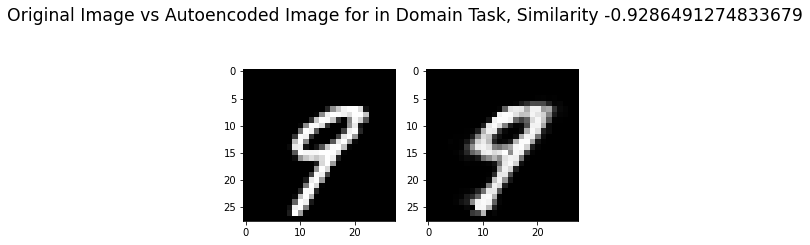

In [8]:
random_index = np.random.choice(np.arange(digit_x_test.shape[0]))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Original Image vs Autoencoded Image for in Domain Task, Similarity {test_similarities[random_index]}', fontsize = 'xx-large')
ax1.imshow(digit_x_test[random_index], cmap = 'Greys_r')
ax2.imshow(autoencode[random_index].reshape(digit_x_test[random_index].shape), cmap = 'Greys_r')
plt.show()

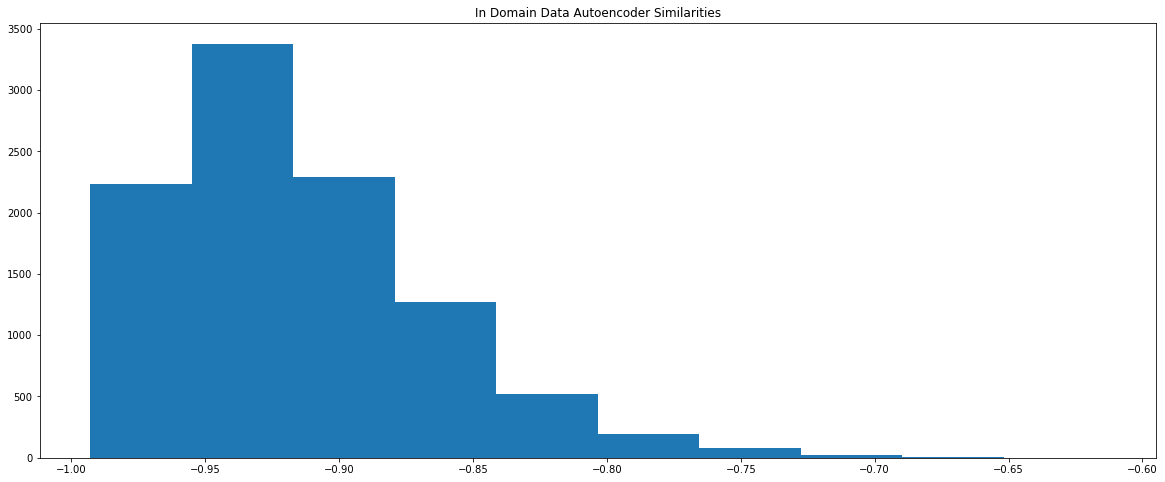

In [9]:
plt.figure(figsize = (20, 8))
plt.title('In Domain Data Autoencoder Similarities')
plt.hist(test_similarities)
plt.show()

In [10]:
print(f'Average in Domain Similarity Score: {test_similarities.mean()}')
print(f'In Domain Similarity Score Standard Deviation: {test_similarities.std()}')

Average in Domain Similarity Score: -0.915023922920227
In Domain Similarity Score Standard Deviation: 0.04895294830203056


In [11]:
preds, autoencode = model.predict(fashion_x_test)
preds = preds.argmax(axis = 1)
test_similarities = tf.keras.losses.cosine_similarity(fashion_x_test.astype('float32').reshape(10000, 784), autoencode.astype('float32')).numpy()

In [12]:
print(classification_report(fashion_y_test, preds))

              precision    recall  f1-score   support

           0       0.01      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.01      0.00      1000
           3       0.29      0.25      0.27      1000
           4       0.03      0.00      0.00      1000
           5       0.03      0.10      0.04      1000
           6       0.14      0.10      0.12      1000
           7       0.30      0.01      0.02      1000
           8       0.16      0.13      0.14      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.06     10000
   macro avg       0.10      0.06      0.06     10000
weighted avg       0.10      0.06      0.06     10000



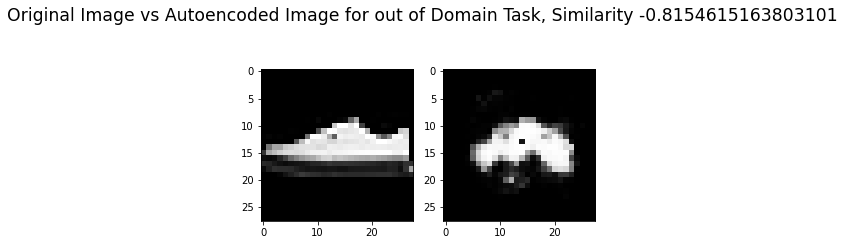

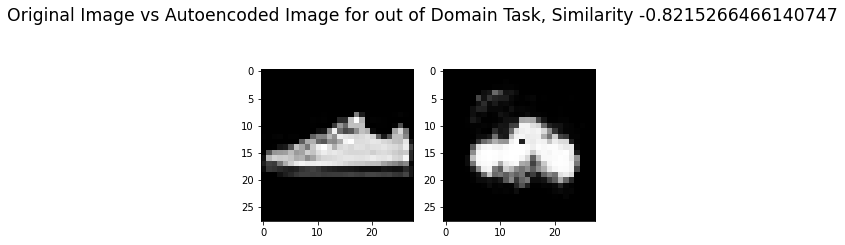

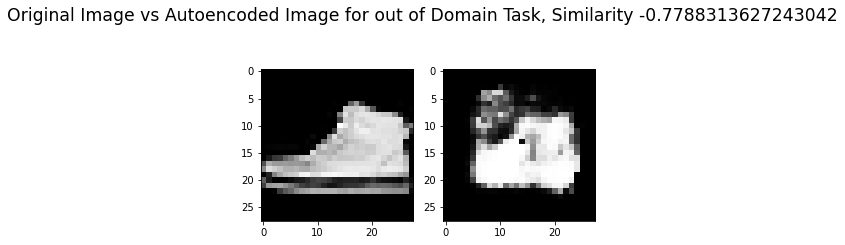

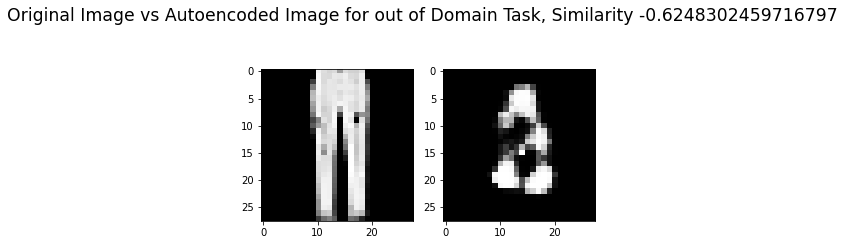

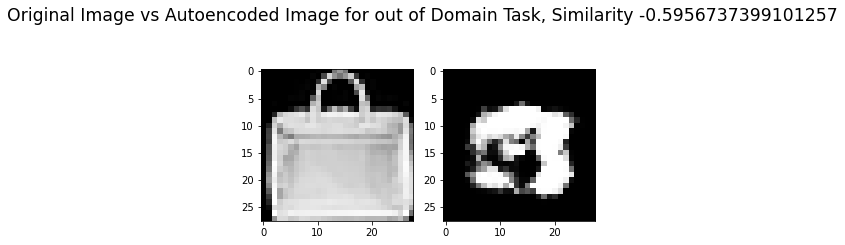

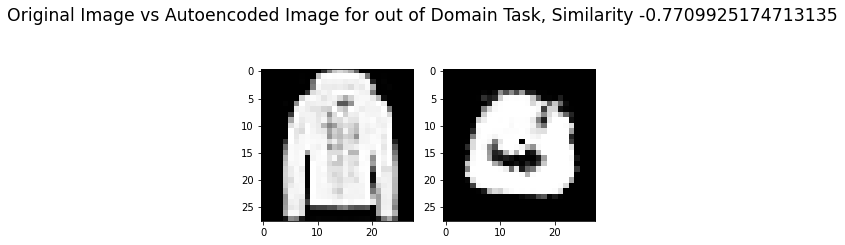

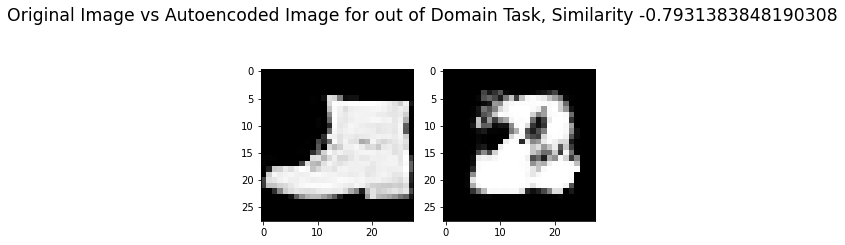

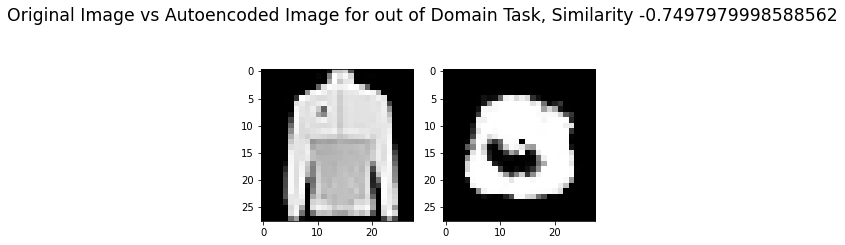

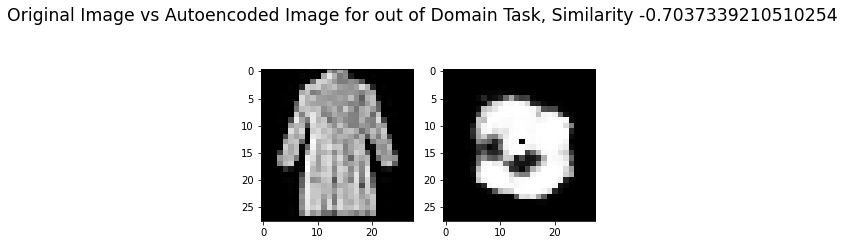

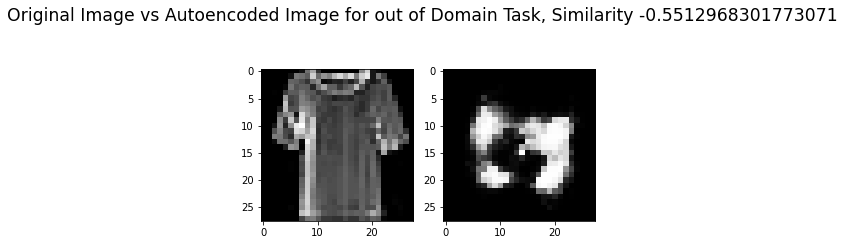

In [13]:
for random_index in np.random.choice(np.arange(fashion_x_test.shape[0]), 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Original Image vs Autoencoded Image for out of Domain Task, Similarity {test_similarities[random_index]}', fontsize = 'xx-large')
    ax1.imshow(fashion_x_test[random_index], cmap = 'Greys_r')
    ax2.imshow(autoencode[random_index].reshape(fashion_x_test[random_index].shape), cmap = 'Greys_r')
    plt.show()

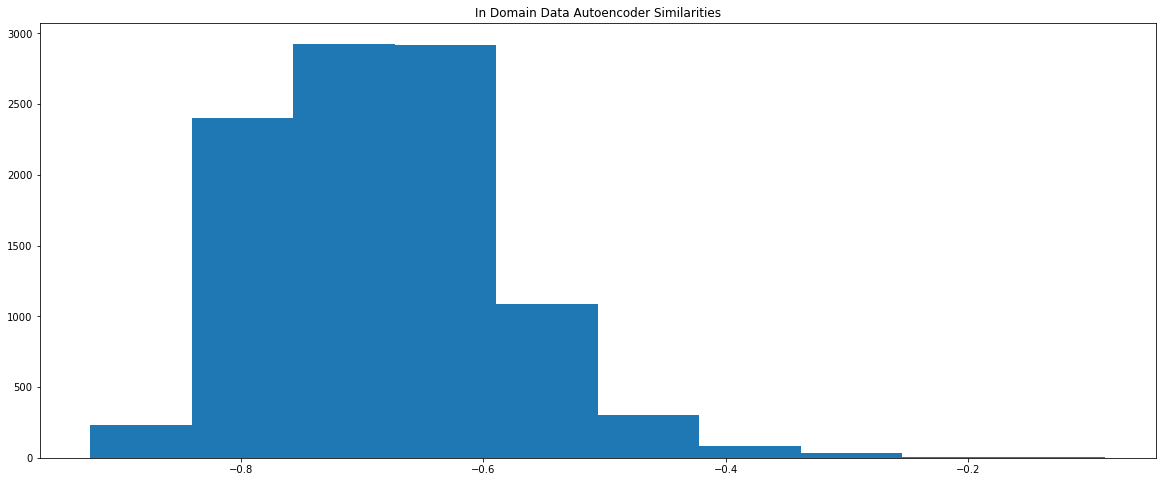

In [14]:
plt.figure(figsize = (20, 8))
plt.title('In Domain Data Autoencoder Similarities')
plt.hist(test_similarities)
plt.show()

In [15]:
print(f'Average Out of Domain Similarity Score: {test_similarities.mean()}')
print(f'Out of Domain Similarity Score Standard Deviation: {test_similarities.std()}')

Average Out of Domain Similarity Score: -0.6834625005722046
Out of Domain Similarity Score Standard Deviation: 0.09853656589984894
